## Idea:

With so much pictures to go through, try basic photographic data (ISO, aperture, ExposureTime, FocusLength, ShutterSpeed, maybe also White Balance Information to perform sorting and then check if it is useful enough)

In [55]:
import pandas as pd
import numpy as np
import os
import string
import datetime
from datetime import timezone
os.getcwd()
import glob
import pytz
import seaborn as sns
import re

import scikitplot as skplt
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv("pictureData/PhotoEXIFDataStripped_2006_2020_CorrectDates_New.csv")
df=df.drop(columns=['Unnamed: 0'])

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df['FNumber'].unique()

array([3.3, 4.0, 5.6, 5.0, 2.8, 3.2, 3.1, 4.5, 3.5, 3.7, 2.9, 3.0, 3.4,
       8.0, 6.3, 7.1, 2.0, 3.6, nan, 5.9, 6.4, 2.4, 10.0, 13.0, 9.0, 11.0,
       16.0, 14.0, 22.0, 20.0, 18.0, 4.9, 3.9, 4.2, 2.5, 2.2, '2.0',
       '7.1', '8.0', '3.5', '5.0', '4.0', '5.6', '4.5', '9.0', '2.5',
       '2.2', '3.2', '11.0', '10.0', '2.8', '6.3', '13.0', '16.0', '14.0',
       '5.9', 'undef', '2.6', '3.3', '5.8', '6.4', '22.0', '20.0', '29.0',
       '6.1', '36.0', '18.0', '32.0', '25.0', '6.9', '3.4', '3.6', '1.8',
       '2.7', '1.6', '1.9', '2.4', 5.2, 1.7, 5.3, 5.4, 4.7, 5.1, 5.5, 4.6,
       4.1, 4.4, 4.3, 6.0, 3.8, 6.1, 4.8], dtype=object)

In [4]:
df['FNumber'] = df['FNumber'].replace({'undef': np.nan})
df['FNumber']=pd.to_numeric(df['FNumber'])

In [5]:
df[['FocalLength in mm','FocalLength35efl']]

,FocalLength in mm,FocalLength35efl
0,18.5,18.5 mm (35 mm equivalent: 3035.5 mm)
1,33.0,33.0 mm (35 mm equivalent: 5414.7 mm)
2,20.9,20.9 mm (35 mm equivalent: 126.3 mm)
3,14.9,14.9 mm (35 mm equivalent: 90.0 mm)
4,14.9,14.9 mm (35 mm equivalent: 90.0 mm)
...,...,...
102316,18.0,18.0 mm (35 mm equivalent: 28.0 mm)
102317,56.0,56.0 mm (35 mm equivalent: 87.0 mm)
102318,135.0,135.0 mm (35 mm equivalent: 209.8 mm)
102319,42.0,42.0 mm (35 mm equivalent: 65.3 mm)


### Extract equivalent 35 mm Focal Length

Use reg exp to extract the digits (and the dot) everything following the equivalent patterns, and before th space mm, pay attention to put a slash in front of the bracket to notify we want the string

In [6]:
df['FocalLength35efl in mm'] = df['FocalLength35efl'].str.extract('((?<=equivalent: ).*(?= mm\)))')
df['FocalLength35efl in mm'] =pd.to_numeric(df['FocalLength35efl in mm'])
df['FocalLength35efl in mm']

0         3035.5
1         5414.7
2          126.3
3           90.0
4           90.0
           ...  
102316      28.0
102317      87.0
102318     209.8
102319      65.3
102320      91.7
Name: FocalLength35efl in mm, Length: 102321, dtype: float64

In [7]:
df.dtypes

SourceFile                 object
Aperture                  float64
BitsPerSample             float64
ColorSpace                 object
Contrast                   object
CreateDate                 object
Date                       object
ExposureTime              float64
FileName                   object
Flash                      object
FNumber                   float64
FocalLength in mm         float64
FocalLength35efl           object
ImageSize                  object
ImageWidth                float64
ISO                       float64
LightValue                float64
Model                      object
Orientation                object
Quality                    object
ShutterSpeed              float64
WhiteBalance               object
Place                      object
year                        int64
dayperiod                   int64
CompositePhoto              int64
Movie                       int64
ApertureValue             float64
BlueBalance               float64
ColorTempAsSho

In [8]:
df

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day,FocalLength35efl in mm
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,3035.5
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,5414.7
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,126.3
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,90.0
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,0,NaN,NaN,NaN,NaN,NaN,NaN,France,2006-11-25,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102316,/2020/201201-201228 - Lauchringen/PC110001 - L...,3.5,8.0,sRGB,Normal,2020:12:11 20:28:08,2020-12-11 20:28:08,30.00000,"PC110001 - Lauchringen, Dorf im Schnee.JPG","Off, Did not fire",...,0,3.5,2.381836,3239.0,0.0,NaN,1293 1024 1024 2439,Germany,2020-12-11,28.0
102317,/2020/201201-201228 - Lauchringen/PC010006 - L...,5.0,8.0,sRGB,Normal,2020:12:01 09:08:01,2020-12-01 09:08:01,0.02000,"PC010006 - Lauchringen, Baeume mit Schnee.JPG","Off, Did not fire",...,0,5.0,1.544922,6073.0,0.0,0.020408,1938 1024 1024 1582,Germany,2020-12-01,87.0
102318,/2020/201201-201228 - Lauchringen/PC030003 - L...,5.6,8.0,sRGB,Normal,2020:12:03 14:55:21,2020-12-03 14:55:21,0.00500,"PC030003 - Lauchringen, Kuessaberg mit Kuessab...","Off, Did not fire",...,0,5.7,1.684570,5200.0,0.0,0.005076,1824 1024 1024 1725,Germany,2020-12-03,209.8
102319,/2020/201201-201228 - Lauchringen/PC010014 - L...,7.1,8.0,sRGB,Normal,2020:12:01 11:18:33,2020-12-01 11:18:33,0.00625,"PC010014 - Lauchringen, Wald mit Schnee.JPG","Off, Did not fire",...,0,7.0,1.584961,5816.0,0.0,0.006024,1913 1024 1024 1623,Germany,2020-12-01,65.3


In [34]:
obj_col_list= [col for col in df.columns if df[col].dtype=='object']
obj_col_list

['SourceFile',
 'ColorSpace',
 'Contrast',
 'CreateDate',
 'Date',
 'FileName',
 'Flash',
 'FocalLength35efl',
 'ImageSize',
 'Model',
 'Orientation',
 'Quality',
 'WhiteBalance',
 'Place',
 'WB_RGGBLevelsAsShot',
 'Country',
 'Day']

In [44]:
df['Model'].unique()

array(['SP500UZ', 'C750UZ', 'MAXXUM 7D', 'DSC-W70',
       'Canon EOS 350D DIGITAL', 'NIKON D200', 'Canon DIGITAL IXUS v3',
       'uD600,S600', 'SP510UZ', 'Canon DIGITAL IXUS 800 IS', nan,
       'EX-Z80', 'Canon PowerShot SX200 IS', 'NIKON D90', 'NIKON D3100',
       'Canon EOS 1000D', 'C5-00.2', 'Canon EOS 600D', 'DMC-TZ10',
       'Canon PowerShot SX220 HS', 'Canon PowerShot S110', 'GT-I8200N',
       'DMC-TZ71', 'Canon PowerShot SX720 HS', 'Canon EOS 80D', 'Pixel 2',
       'iPhone 6s', 'COOLPIX S5100', 'LM-G710', 'NIKON D5100', 'iPhone 8',
       'Xperia XA2', 'HTC One', 'SM-G930F'], dtype=object)

In [45]:
#18619 photos for olympus ultrazoom camera
df[df['Model']=='SP500UZ'].isna().sum()

SourceFile                    0
Aperture                     95
BitsPerSample                 0
ColorSpace                    0
Contrast                     95
CreateDate                    0
Date                          0
ExposureTime                 95
FileName                      0
Flash                        95
FNumber                      95
FocalLength in mm            95
FocalLength35efl             95
ImageSize                     0
ImageWidth                    0
ISO                          95
LightValue                   95
Model                         0
Orientation                 256
Quality                    4607
ShutterSpeed               3124
WhiteBalance                 95
Place                         0
year                          0
dayperiod                     0
CompositePhoto                0
Movie                         0
ApertureValue             18383
BlueBalance               18619
ColorTempAsShot           18619
FlashActivity             18619
ShutterS

In [9]:
for col in df.columns:
    print(col,df[col].dtype,df[col].isna().sum())

SourceFile object 0
Aperture float64 1859
BitsPerSample float64 0
ColorSpace object 28
Contrast object 10667
CreateDate object 24
Date object 24
ExposureTime float64 1755
FileName object 0
Flash object 1755
FNumber float64 1859
FocalLength in mm float64 1755
FocalLength35efl object 1755
ImageSize object 0
ImageWidth float64 0
ISO float64 1861
LightValue float64 1861
Model object 130
Orientation object 1520
Quality object 15728
ShutterSpeed float64 5463
WhiteBalance object 1755
Place object 0
year int64 0
dayperiod int64 0
CompositePhoto int64 0
Movie int64 0
ApertureValue float64 20445
BlueBalance float64 32118
ColorTempAsShot float64 32453
FlashActivity float64 32172
ShutterSpeedValue float64 21151
WB_RGGBLevelsAsShot object 32453
Country object 0
Day object 713
FocalLength35efl in mm float64 6382


In [10]:
df[df['Quality'].notna()][['Aperture','WhiteBalance','WB_RGGBLevelsAsShot']].sort_values(by=['WhiteBalance'])

,Aperture,WhiteBalance,WB_RGGBLevelsAsShot
0,3.3,Auto,NaN
71140,5.6,Auto,1889 1024 1024 1683
71139,4.5,Auto,1509 1024 1024 2383
71138,4.0,Auto,1417 1024 1024 2433
71137,3.5,Auto,1502 1024 1024 2203
...,...,...,...
24184,3.5,Tungsten,1544 1024 1024 2351
24183,3.5,Tungsten,1544 1024 1024 2351
24182,3.5,Tungsten,1544 1024 1024 2351
24196,4.5,Tungsten,1544 1024 1024 2351


I never checked it before, but there are (indeed very rate) cases where WB_G1Level and WB_G2Level disagree, but only by very small amounts, for any useful work use though only one of them

In [11]:
df[['WB_RLevel','WB_G1Level','WB_G2Level','WB_BLevel']]=df['WB_RGGBLevelsAsShot'].str.split(' ',4,expand=True)
df[['WB_RLevel','WB_G1Level','WB_G2Level','WB_BLevel']] = df[['WB_RLevel','WB_G1Level','WB_G2Level','WB_BLevel']].apply(pd.to_numeric, errors='coerce')

In [12]:
df

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day,FocalLength35efl in mm,WB_RLevel,WB_G1Level,WB_G2Level,WB_BLevel
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,3035.5,NaN,NaN,NaN,NaN
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,5414.7,NaN,NaN,NaN,NaN
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,126.3,NaN,NaN,NaN,NaN
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,90.0,NaN,NaN,NaN,NaN
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,90.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102316,/2020/201201-201228 - Lauchringen/PC110001 - L...,3.5,8.0,sRGB,Normal,2020:12:11 20:28:08,2020-12-11 20:28:08,30.00000,"PC110001 - Lauchringen, Dorf im Schnee.JPG","Off, Did not fire",...,0.0,NaN,1293 1024 1024 2439,Germany,2020-12-11,28.0,1293.0,1024.0,1024.0,2439.0
102317,/2020/201201-201228 - Lauchringen/PC010006 - L...,5.0,8.0,sRGB,Normal,2020:12:01 09:08:01,2020-12-01 09:08:01,0.02000,"PC010006 - Lauchringen, Baeume mit Schnee.JPG","Off, Did not fire",...,0.0,0.020408,1938 1024 1024 1582,Germany,2020-12-01,87.0,1938.0,1024.0,1024.0,1582.0
102318,/2020/201201-201228 - Lauchringen/PC030003 - L...,5.6,8.0,sRGB,Normal,2020:12:03 14:55:21,2020-12-03 14:55:21,0.00500,"PC030003 - Lauchringen, Kuessaberg mit Kuessab...","Off, Did not fire",...,0.0,0.005076,1824 1024 1024 1725,Germany,2020-12-03,209.8,1824.0,1024.0,1024.0,1725.0
102319,/2020/201201-201228 - Lauchringen/PC010014 - L...,7.1,8.0,sRGB,Normal,2020:12:01 11:18:33,2020-12-01 11:18:33,0.00625,"PC010014 - Lauchringen, Wald mit Schnee.JPG","Off, Did not fire",...,0.0,0.006024,1913 1024 1024 1623,Germany,2020-12-01,65.3,1913.0,1024.0,1024.0,1623.0


In [21]:
df[(df['WB_G1Level']!=df['WB_G2Level']) & (df['WB_G1Level'].notna())]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day,FocalLength35efl in mm,WB_RLevel,WB_G1Level,WB_G2Level,WB_BLevel
1810,"/2007/Private/Diplomfeier/P5040004 - Zuerich, ...",5.6,8.0,sRGB,+1,2007:04:27 15:38:19,2007-04-27 15:38:19,0.020000,"P5040004 - Zuerich, Buehne im Audi-Max.JPG","Off, Did not fire",...,0.0,0.020000,2207 1220 1217 2563,Switzerland,NaN,89.2,2207.0,1220.0,1217.0,2563.0
1811,"/2007/Private/Diplomfeier/P5040005 - Zuerich, ...",5.0,8.0,sRGB,+1,2007:04:27 15:49:33,2007-04-27 15:49:33,0.016667,"P5040005 - Zuerich, Matthias, Esther, Ebi, Pat...","Off, Did not fire",...,0.0,0.016667,2508 1020 1018 1445,Switzerland,NaN,29.2,2508.0,1020.0,1018.0,1445.0
1812,"/2007/Private/Diplomfeier/P5040007 - Zuerich, ...",4.0,8.0,sRGB,+1,2007:04:27 16:01:58,2007-04-27 16:01:58,0.016667,"P5040007 - Zuerich, Diplomfeier.JPG","On, Fired",...,0.0,0.016667,2367 1020 1018 1400,Switzerland,NaN,45.4,2367.0,1020.0,1018.0,1400.0
1813,"/2007/Private/Diplomfeier/P5040008 - Zuerich, ...",5.6,8.0,sRGB,+1,2007:04:27 16:02:49,2007-04-27 16:02:49,0.016667,"P5040008 - Zuerich, Joerg Froehlich.JPG","On, Fired",...,0.0,0.016667,2502 1020 1018 1339,Switzerland,NaN,79.5,2502.0,1020.0,1018.0,1339.0
1814,"/2007/Private/Diplomfeier/P5040009 - Zuerich, ...",4.0,8.0,sRGB,+1,2007:04:27 16:25:23,2007-04-27 16:25:23,0.016667,"P5040009 - Zuerich, Diplomfeier.JPG","On, Fired",...,0.0,0.016667,2330 1020 1018 1423,Switzerland,NaN,29.2,2330.0,1020.0,1018.0,1423.0
1815,"/2007/Private/Diplomfeier/P5040010 - Zuerich, ...",5.0,8.0,sRGB,+1,2007:04:27 16:25:51,2007-04-27 16:25:51,0.016667,"P5040010 - Zuerich, Diplomfeier.JPG","On, Fired",...,0.0,0.016667,2473 1020 1018 1353,Switzerland,NaN,63.3,2473.0,1020.0,1018.0,1353.0
1818,"/2007/Private/Diplomfeier/P5040014 - Zuerich, ...",5.6,8.0,sRGB,+1,2007:04:27 16:29:03,2007-04-27 16:29:03,0.016667,"P5040014 - Zuerich, Diplomfeier.JPG","On, Fired",...,0.0,0.016667,2491 1020 1018 1344,Switzerland,NaN,89.2,2491.0,1020.0,1018.0,1344.0
1820,"/2007/Private/Diplomfeier/P5040016 - Zuerich, ...",4.0,8.0,sRGB,+1,2007:04:27 15:33:30,2007-04-27 15:33:30,0.016667,"P5040016 - Zuerich, Esther & Susanne.JPG","On, Fired",...,0.0,0.016667,2356 1020 1018 1499,Switzerland,NaN,35.7,2356.0,1020.0,1018.0,1499.0
1822,"/2007/Private/Diplomfeier/P5040006 - Zuerich, ...",5.0,8.0,sRGB,+1,2007:04:27 15:49:49,2007-04-27 15:49:49,0.016667,"P5040006 - Zuerich, Matthias, Esther, Ebi, Pat...","Off, Did not fire",...,0.0,0.016667,2508 1020 1018 1447,Switzerland,NaN,29.2,2508.0,1020.0,1018.0,1447.0
1823,"/2007/Private/Diplomfeier/P5040012 - Zuerich, ...",5.6,8.0,sRGB,+1,2007:04:27 16:26:55,2007-04-27 16:26:55,0.016667,"P5040012 - Zuerich, Diplomfeier.JPG","On, Fired",...,0.0,0.016667,2479 1020 1018 1346,Switzerland,NaN,89.2,2479.0,1020.0,1018.0,1346.0


In [16]:
df[(df['WB_G2Level'].notna())]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day,FocalLength35efl in mm,WB_RLevel,WB_G1Level,WB_G2Level,WB_BLevel
1810,"/2007/Private/Diplomfeier/P5040004 - Zuerich, ...",5.6,8.0,sRGB,+1,2007:04:27 15:38:19,2007-04-27 15:38:19,0.020000,"P5040004 - Zuerich, Buehne im Audi-Max.JPG","Off, Did not fire",...,0.0,0.020000,2207 1220 1217 2563,Switzerland,NaN,89.2,2207.0,1220.0,1217.0,2563.0
1811,"/2007/Private/Diplomfeier/P5040005 - Zuerich, ...",5.0,8.0,sRGB,+1,2007:04:27 15:49:33,2007-04-27 15:49:33,0.016667,"P5040005 - Zuerich, Matthias, Esther, Ebi, Pat...","Off, Did not fire",...,0.0,0.016667,2508 1020 1018 1445,Switzerland,NaN,29.2,2508.0,1020.0,1018.0,1445.0
1812,"/2007/Private/Diplomfeier/P5040007 - Zuerich, ...",4.0,8.0,sRGB,+1,2007:04:27 16:01:58,2007-04-27 16:01:58,0.016667,"P5040007 - Zuerich, Diplomfeier.JPG","On, Fired",...,0.0,0.016667,2367 1020 1018 1400,Switzerland,NaN,45.4,2367.0,1020.0,1018.0,1400.0
1813,"/2007/Private/Diplomfeier/P5040008 - Zuerich, ...",5.6,8.0,sRGB,+1,2007:04:27 16:02:49,2007-04-27 16:02:49,0.016667,"P5040008 - Zuerich, Joerg Froehlich.JPG","On, Fired",...,0.0,0.016667,2502 1020 1018 1339,Switzerland,NaN,79.5,2502.0,1020.0,1018.0,1339.0
1814,"/2007/Private/Diplomfeier/P5040009 - Zuerich, ...",4.0,8.0,sRGB,+1,2007:04:27 16:25:23,2007-04-27 16:25:23,0.016667,"P5040009 - Zuerich, Diplomfeier.JPG","On, Fired",...,0.0,0.016667,2330 1020 1018 1423,Switzerland,NaN,29.2,2330.0,1020.0,1018.0,1423.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102316,/2020/201201-201228 - Lauchringen/PC110001 - L...,3.5,8.0,sRGB,Normal,2020:12:11 20:28:08,2020-12-11 20:28:08,30.000000,"PC110001 - Lauchringen, Dorf im Schnee.JPG","Off, Did not fire",...,0.0,NaN,1293 1024 1024 2439,Germany,2020-12-11,28.0,1293.0,1024.0,1024.0,2439.0
102317,/2020/201201-201228 - Lauchringen/PC010006 - L...,5.0,8.0,sRGB,Normal,2020:12:01 09:08:01,2020-12-01 09:08:01,0.020000,"PC010006 - Lauchringen, Baeume mit Schnee.JPG","Off, Did not fire",...,0.0,0.020408,1938 1024 1024 1582,Germany,2020-12-01,87.0,1938.0,1024.0,1024.0,1582.0
102318,/2020/201201-201228 - Lauchringen/PC030003 - L...,5.6,8.0,sRGB,Normal,2020:12:03 14:55:21,2020-12-03 14:55:21,0.005000,"PC030003 - Lauchringen, Kuessaberg mit Kuessab...","Off, Did not fire",...,0.0,0.005076,1824 1024 1024 1725,Germany,2020-12-03,209.8,1824.0,1024.0,1024.0,1725.0
102319,/2020/201201-201228 - Lauchringen/PC010014 - L...,7.1,8.0,sRGB,Normal,2020:12:01 11:18:33,2020-12-01 11:18:33,0.006250,"PC010014 - Lauchringen, Wald mit Schnee.JPG","Off, Did not fire",...,0.0,0.006024,1913 1024 1024 1623,Germany,2020-12-01,65.3,1913.0,1024.0,1024.0,1623.0


## Information encoded in different features

With my preferred settings some values are identical, clearly Aperture/ShutterSpeed and corresponding ApertureValue/ShutterSpeedValue contain the same information, similarly WB_G1Level is almost always the same as WB_G2Level (10 exceptions), Aperture and FNumber are indistinguisable, BlueBalance and WB_BLevel include very similar information, ExposureTime and ShutterSpeed are highly correlated.

Since three different cameras dominate the scence, the FocalLength vs FocalLength35efl show 3 different correlation lines.

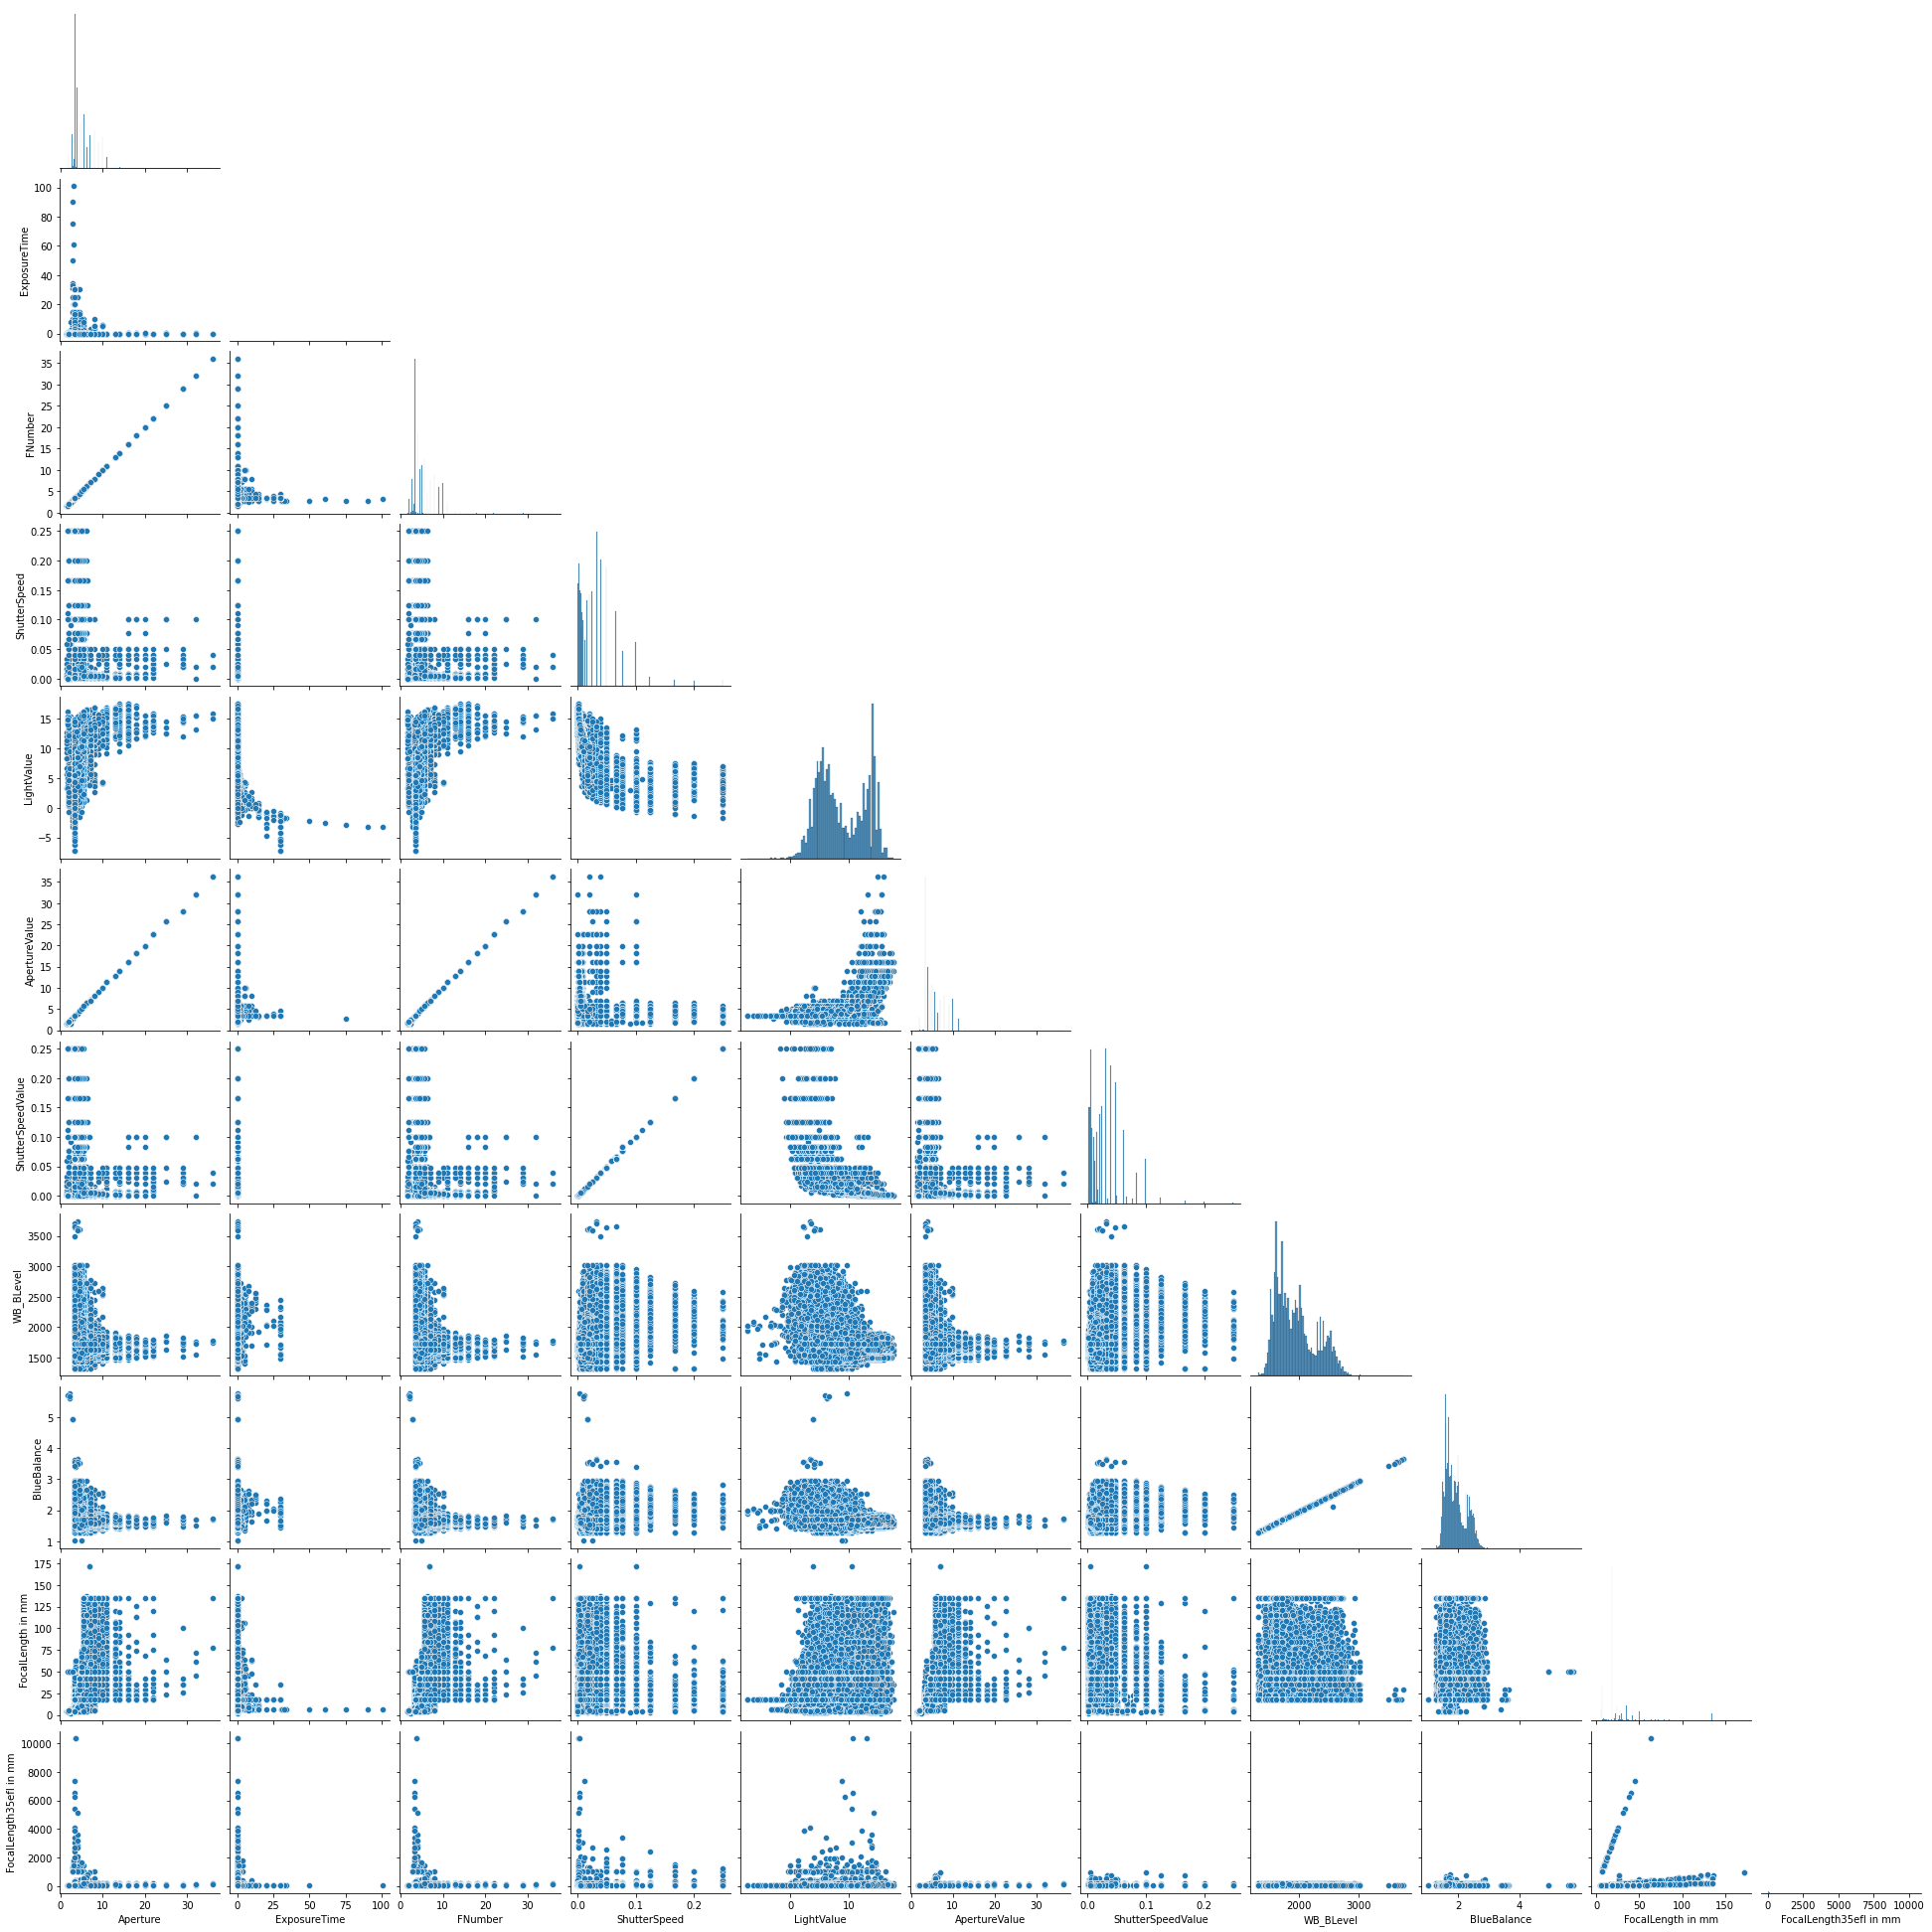

In [25]:
sns.pairplot(data=df,x_vars=['Aperture','ExposureTime','FNumber','ShutterSpeed','LightValue',
                             'ApertureValue','ShutterSpeedValue','WB_BLevel','BlueBalance',
                             'FocalLength in mm','FocalLength35efl in mm'],
            y_vars=['Aperture','ExposureTime','FNumber','ShutterSpeed','LightValue',
                             'ApertureValue','ShutterSpeedValue','WB_BLevel','BlueBalance',
                             'FocalLength in mm','FocalLength35efl in mm'], corner=True)

<AxesSubplot:xlabel='ExposureTime', ylabel='ShutterSpeed'>

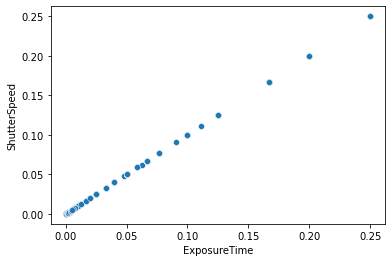

In [27]:
sns.scatterplot(x='ExposureTime',y='ShutterSpeed', data=df)

<AxesSubplot:>

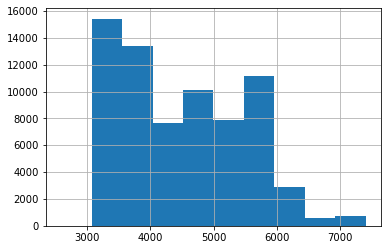

In [28]:
df['ColorTempAsShot'].hist()

In [22]:
df.drop(columns=['SourceFile','CreateDate','Date','WB_RGGBLevelsAsShot','FileName']).corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,Aperture,BitsPerSample,ExposureTime,FNumber,FocalLength in mm,ImageWidth,ISO,LightValue,ShutterSpeed,year,dayperiod,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,FocalLength35efl in mm,WB_RLevel,WB_G1Level,WB_G2Level,WB_BLevel
Aperture,1.00,nan,-0.07,1.00,0.35,0.29,-0.20,0.75,-0.48,0.23,0.13,0.01,-0.00,1.00,-0.57,0.61,-0.00,-0.59,0.06,0.53,0.00,0.00,-0.58
BitsPerSample,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ExposureTime,-0.07,nan,1.00,-0.07,-0.04,-0.08,-0.01,-0.16,1.00,-0.07,-0.15,-0.00,-0.00,-0.05,0.04,-0.05,-0.00,1.00,0.00,-0.03,-0.00,-0.00,0.04
FNumber,1.00,nan,-0.07,1.00,0.35,0.29,-0.20,0.75,-0.48,0.23,0.13,0.01,-0.00,1.00,-0.57,0.61,-0.00,-0.59,0.06,0.53,0.00,0.00,-0.58
FocalLength in mm,0.35,nan,-0.04,0.35,1.00,0.31,0.04,0.23,-0.17,0.27,0.04,0.01,0.00,0.31,-0.15,0.20,-0.00,-0.21,0.35,0.13,0.00,0.00,-0.15
ImageWidth,0.29,nan,-0.08,0.29,0.31,1.00,0.23,-0.10,-0.01,0.73,0.11,0.28,-0.12,0.16,0.09,0.08,-0.04,-0.13,-0.18,-0.48,-0.02,-0.02,0.09
ISO,-0.20,nan,-0.01,-0.20,0.04,0.23,1.00,-0.48,0.23,0.26,-0.07,-0.00,0.02,-0.27,0.38,-0.35,-0.00,0.28,-0.05,-0.38,-0.00,-0.00,0.38
LightValue,0.75,nan,-0.16,0.75,0.23,-0.10,-0.48,1.00,-0.69,-0.09,0.18,0.01,-0.02,0.86,-0.70,0.73,0.00,-0.75,0.15,0.64,-0.00,0.00,-0.70
ShutterSpeed,-0.48,nan,1.00,-0.48,-0.17,-0.01,0.23,-0.69,1.00,-0.07,-0.14,-0.00,0.00,-0.60,0.52,-0.56,-0.00,1.00,-0.10,-0.44,-0.00,-0.00,0.52
year,0.23,nan,-0.07,0.23,0.27,0.73,0.26,-0.09,-0.07,1.00,0.12,0.00,0.01,0.07,0.08,0.06,-0.02,-0.20,-0.16,-0.42,-0.01,-0.01,0.09


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22')])

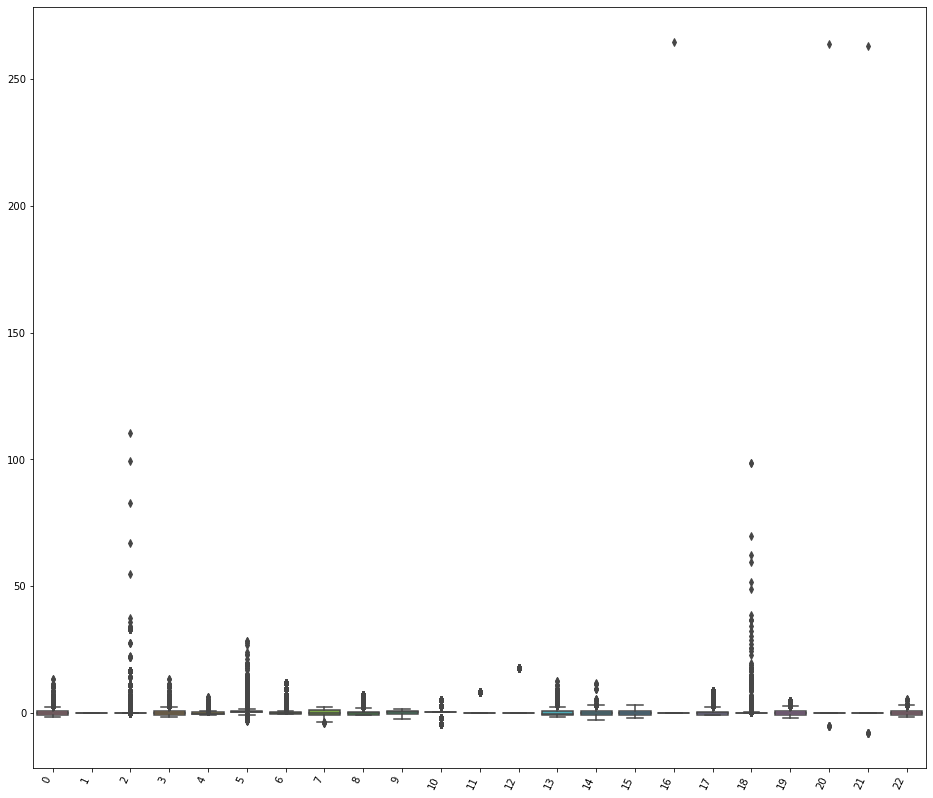

In [37]:
sc = StandardScaler()
df_scaled= pd.DataFrame(sc.fit_transform(df.drop(columns=obj_col_list)))
#columns = df.drop(columns=["customer_id"]).columns)
plt.figure(figsize=(16,14))
sns.boxplot(data = df_scaled)
plt.xticks(rotation=65, horizontalalignment='right')

## Input for Unsupervised Clustering

Input for clustering:
Aperture, ExposureTime, ISO, LightValue, ColorTempAsShot, FocalLength35efl in mm, WB_RLevel, WB_G2Level, WB_BLevel

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

col_for_cluster=['Aperture', 'ExposureTime', 'ISO', 'LightValue', 'ColorTempAsShot', 'FocalLength35efl in mm', 'WB_RLevel', 'WB_G2Level', 'WB_BLevel']

col_for_cluster_w_olymp=['Aperture', 'ExposureTime', 'ISO', 'LightValue', 'FocalLength35efl in mm']



df_nona_col_for_cluster=df.dropna(subset=col_for_cluster)
df_nona_col_for_cluster_w_olymp=df.dropna(subset=col_for_cluster_w_olymp)
df_nona_col_for_cluster_w_olymp

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Day,FocalLength35efl in mm,WB_RLevel,WB_G1Level,WB_G2Level,WB_BLevel
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,3035.5,NaN,NaN,NaN,NaN
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,5414.7,NaN,NaN,NaN,NaN
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,126.3,NaN,NaN,NaN,NaN
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,90.0,NaN,NaN,NaN,NaN
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,France,2006-11-25,90.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102316,/2020/201201-201228 - Lauchringen/PC110001 - L...,3.5,8.0,sRGB,Normal,2020:12:11 20:28:08,2020-12-11 20:28:08,30.00000,"PC110001 - Lauchringen, Dorf im Schnee.JPG","Off, Did not fire",...,0.0,NaN,1293 1024 1024 2439,Germany,2020-12-11,28.0,1293.0,1024.0,1024.0,2439.0
102317,/2020/201201-201228 - Lauchringen/PC010006 - L...,5.0,8.0,sRGB,Normal,2020:12:01 09:08:01,2020-12-01 09:08:01,0.02000,"PC010006 - Lauchringen, Baeume mit Schnee.JPG","Off, Did not fire",...,0.0,0.020408,1938 1024 1024 1582,Germany,2020-12-01,87.0,1938.0,1024.0,1024.0,1582.0
102318,/2020/201201-201228 - Lauchringen/PC030003 - L...,5.6,8.0,sRGB,Normal,2020:12:03 14:55:21,2020-12-03 14:55:21,0.00500,"PC030003 - Lauchringen, Kuessaberg mit Kuessab...","Off, Did not fire",...,0.0,0.005076,1824 1024 1024 1725,Germany,2020-12-03,209.8,1824.0,1024.0,1024.0,1725.0
102319,/2020/201201-201228 - Lauchringen/PC010014 - L...,7.1,8.0,sRGB,Normal,2020:12:01 11:18:33,2020-12-01 11:18:33,0.00625,"PC010014 - Lauchringen, Wald mit Schnee.JPG","Off, Did not fire",...,0.0,0.006024,1913 1024 1024 1623,Germany,2020-12-01,65.3,1913.0,1024.0,1024.0,1623.0


In [64]:
df_nona_col_for_cluster[col_for_cluster]

,Aperture,ExposureTime,ISO,LightValue,ColorTempAsShot,FocalLength35efl in mm,WB_RLevel,WB_G2Level,WB_BLevel
1810,5.6,0.020000,400.0,8.6,2738.0,89.2,2207.0,1217.0,2563.0
1811,5.0,0.016667,400.0,8.6,5452.0,29.2,2508.0,1018.0,1445.0
1812,4.0,0.016667,400.0,7.9,5410.0,45.4,2367.0,1018.0,1400.0
1813,5.6,0.016667,400.0,8.9,5832.0,79.5,2502.0,1018.0,1339.0
1814,4.0,0.016667,400.0,7.9,5284.0,29.2,2330.0,1018.0,1423.0
...,...,...,...,...,...,...,...,...,...
102316,3.5,30.000000,100.0,-1.3,3239.0,28.0,1293.0,1024.0,2439.0
102317,5.0,0.020000,100.0,10.3,6073.0,87.0,1938.0,1024.0,1582.0
102318,5.6,0.005000,100.0,12.6,5200.0,209.8,1824.0,1024.0,1725.0
102319,7.1,0.006250,100.0,13.0,5816.0,65.3,1913.0,1024.0,1623.0


In [47]:
df.isna().sum()

SourceFile                    0
Aperture                   1859
BitsPerSample                 0
ColorSpace                   28
Contrast                  10667
CreateDate                   24
Date                         24
ExposureTime               1755
FileName                      0
Flash                      1755
FNumber                    1859
FocalLength in mm          1755
FocalLength35efl           1755
ImageSize                     0
ImageWidth                    0
ISO                        1861
LightValue                 1861
Model                       130
Orientation                1520
Quality                   15728
ShutterSpeed               5463
WhiteBalance               1755
Place                         0
year                          0
dayperiod                     0
CompositePhoto                0
Movie                         0
ApertureValue             20445
BlueBalance               32118
ColorTempAsShot           32453
FlashActivity             32172
ShutterS

In [51]:
cluster_errors = []
silhouette_s = []
#pip_kmeans_pca_95=Pipeline(steps=[('sc', sc), ('pca', pca_95)])

for n_clusters in range(2, 10):
    kmeans_pipeline = Pipeline(steps=[('sc', sc),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=17, verbose=0))])
    kmeans_pipeline.fit(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp])
    kmeans_pipeline.predict(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp])
    cluster_labels = kmeans_pipeline.fit_predict(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp])
    cluster_errors.append(kmeans_pipeline.named_steps["cluster"].inertia_)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp], cluster_labels))
    silhouette_s.append(silhouette_score(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp], cluster_labels))

For n_clusters = 2 The average silhouette_score is : 0.13308858007132598
For n_clusters = 3 The average silhouette_score is : 0.10586909996588928
For n_clusters = 4 The average silhouette_score is : 0.1847592791838809
For n_clusters = 5 The average silhouette_score is : 0.18324350647014326
For n_clusters = 6 The average silhouette_score is : -0.09221177033399978
For n_clusters = 7 The average silhouette_score is : 0.006279498939189124
For n_clusters = 8 The average silhouette_score is : -0.0006694593783006287
For n_clusters = 9 The average silhouette_score is : -0.08935925943207994


For n_clusters = 2 The average silhouette_score is : 0.13308858007132598
cluster calculation finished, start plotting
sihouette and cluster plots for cluster number:  2
For n_clusters = 3 The average silhouette_score is : 0.10586909996588928
cluster calculation finished, start plotting
sihouette and cluster plots for cluster number:  3
For n_clusters = 4 The average silhouette_score is : 0.1847592791838809
cluster calculation finished, start plotting
sihouette and cluster plots for cluster number:  4
For n_clusters = 5 The average silhouette_score is : 0.18324350647014326
cluster calculation finished, start plotting
sihouette and cluster plots for cluster number:  5
For n_clusters = 6 The average silhouette_score is : -0.09221177033399978
cluster calculation finished, start plotting
sihouette and cluster plots for cluster number:  6
For n_clusters = 7 The average silhouette_score is : 0.006279498939189124
cluster calculation finished, start plotting
sihouette and cluster plots for clus

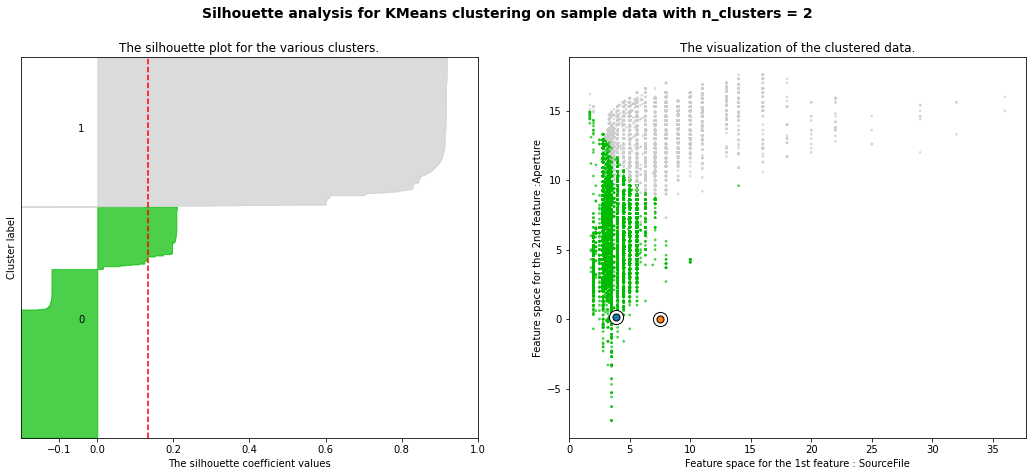

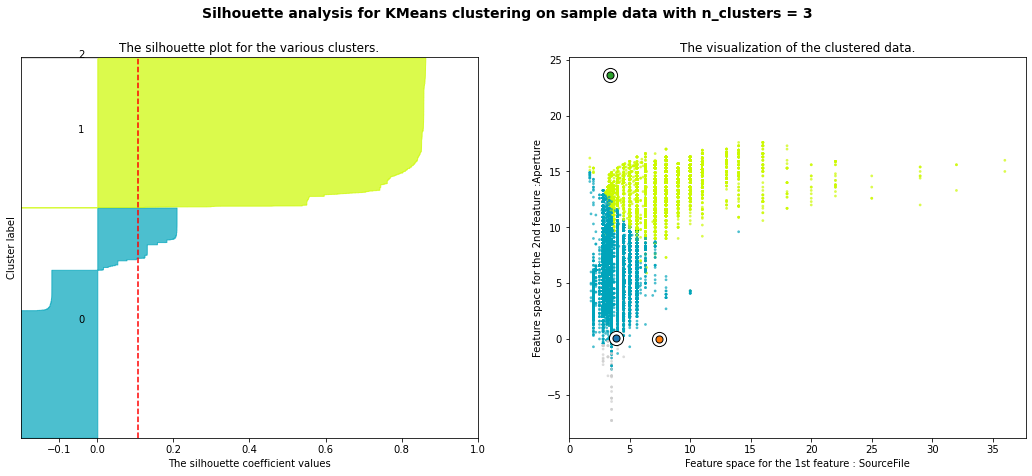

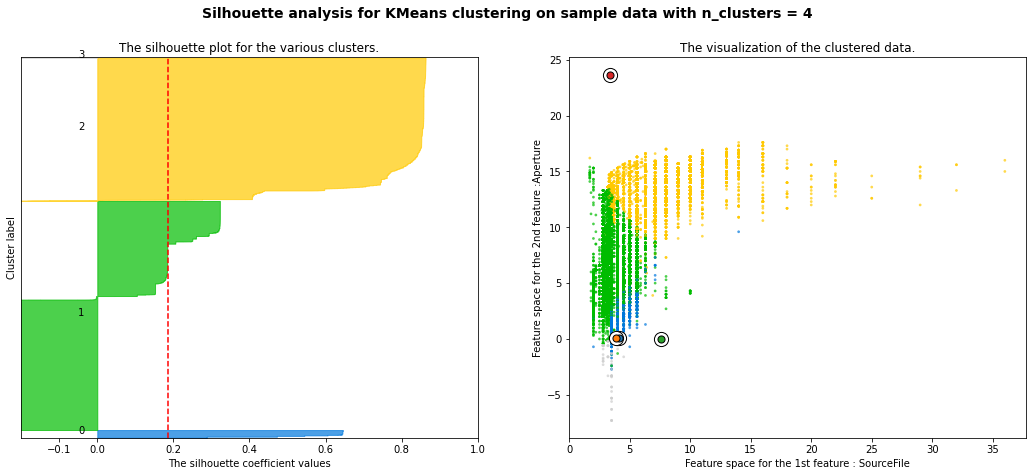

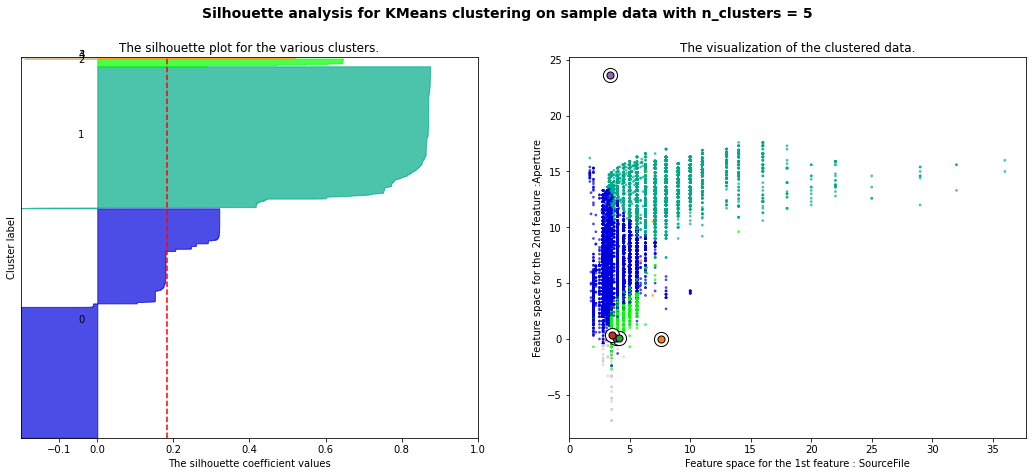

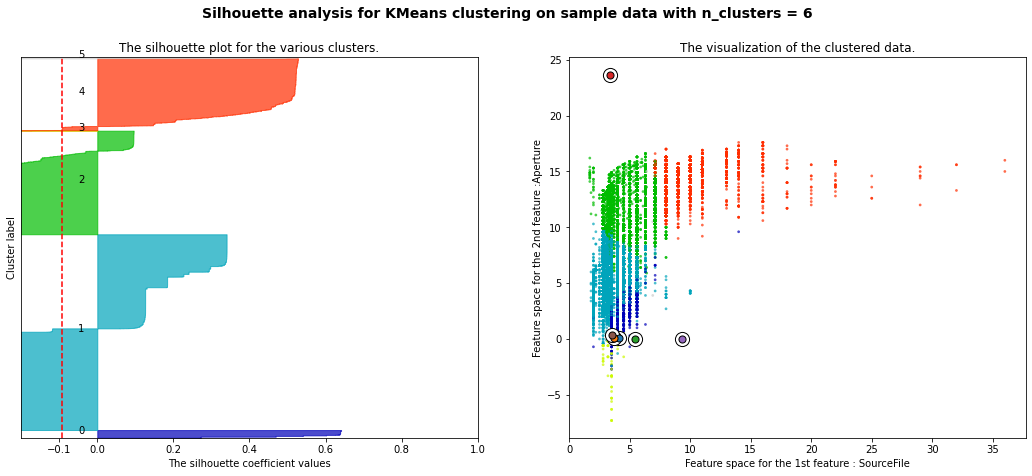

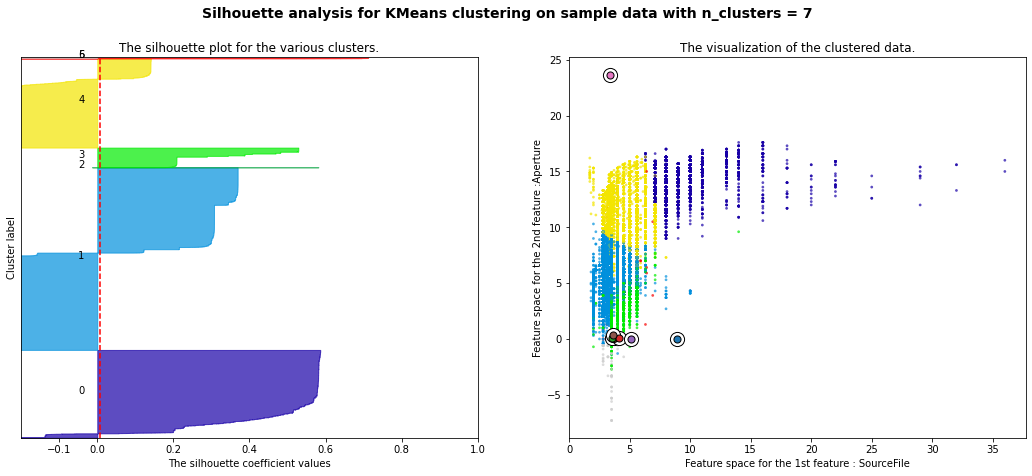

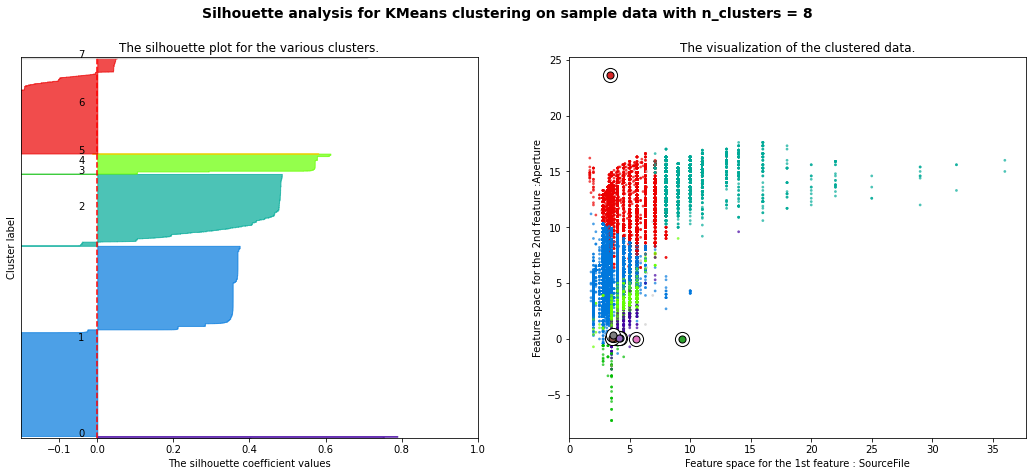

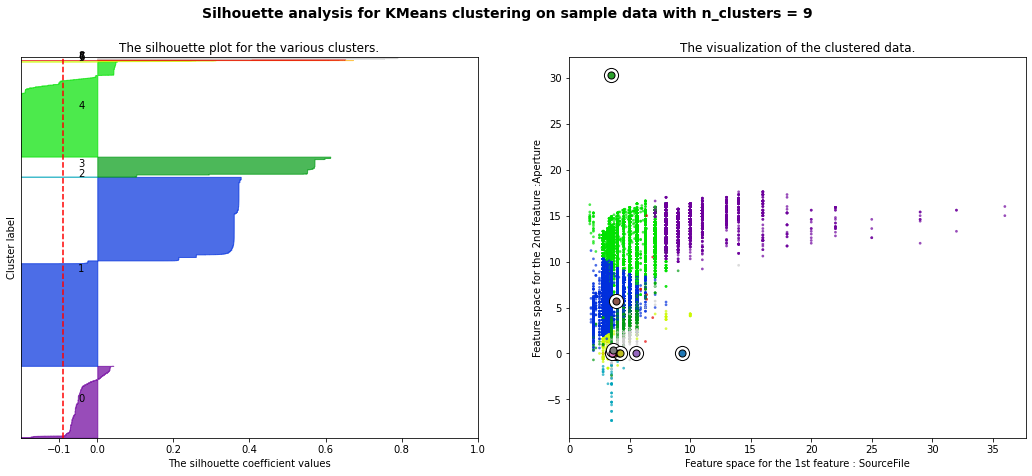

In [59]:
range_n_clusters = range(2, 10)

r_seed = 17

cols = df.columns

cluster_errors = []
silhouette_s = []

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp]) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))])
    
    cluster_labels = kmeans_pipeline.fit_predict(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp], cluster_labels)
    print("For n_clusters =",
          n_clusters,
          "The average silhouette_score is :",
          silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp], cluster_labels)

    cluster_errors.append(kmeans_pipeline.named_steps["cluster"].inertia_)
    silhouette_s.append(silhouette_avg)
    #print('cluster calculation finished, start plotting')
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #print('sihouette and cluster plots for cluster number: ',n_clusters)
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(df_nona_col_for_cluster_w_olymp['Aperture'], 
                df_nona_col_for_cluster_w_olymp['LightValue'], 
                marker=".", 
                s=30, 
                lw=0, 
                alpha=0.7, 
                c=colors, 
                edgecolor="k")

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature : " + cols[0])
    ax2.set_ylabel("Feature space for the 2nd feature :" + cols[1])

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data "
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="_canon_canonbold",
    )
print("\n")
plt.show()

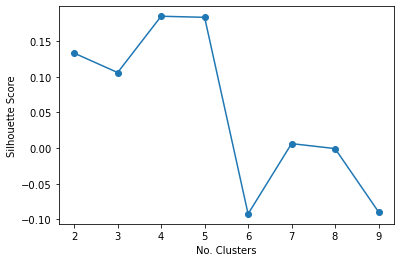

In [60]:
plt.plot(range(2, 10),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.show()

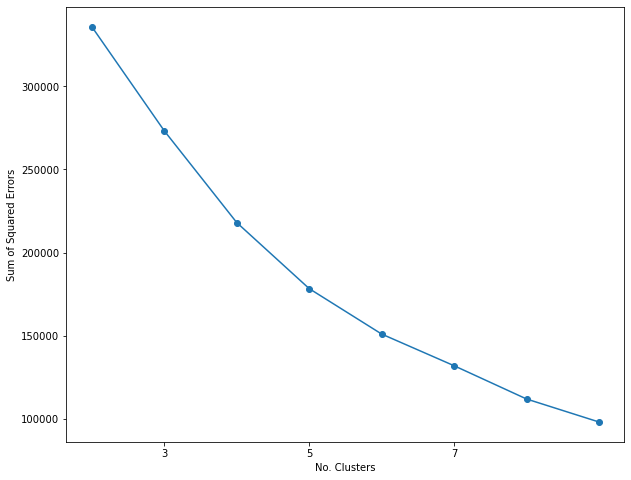

In [62]:
fig = plt.figure(figsize=(10,8))

plt.plot(range(2, 10),cluster_errors, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Sum of Squared Errors")
plt.xticks(np.arange(3, 9, step=2))
plt.savefig("cluster_error_elbow_w_olymp.png")
plt.show()
#plt.savefig("cluster_error_elbow.pdf")

For n_clusters = 2 The average silhouette_score is : 0.4279983141663835
For n_clusters = 3 The average silhouette_score is : 0.2764713577255798
For n_clusters = 4 The average silhouette_score is : 0.24221313870664166
For n_clusters = 5 The average silhouette_score is : 0.3465272961515433
For n_clusters = 6 The average silhouette_score is : 0.10558814881337739
For n_clusters = 7 The average silhouette_score is : 0.1721134082866791
For n_clusters = 8 The average silhouette_score is : 0.13739609688140222
For n_clusters = 9 The average silhouette_score is : 0.17231447811054137




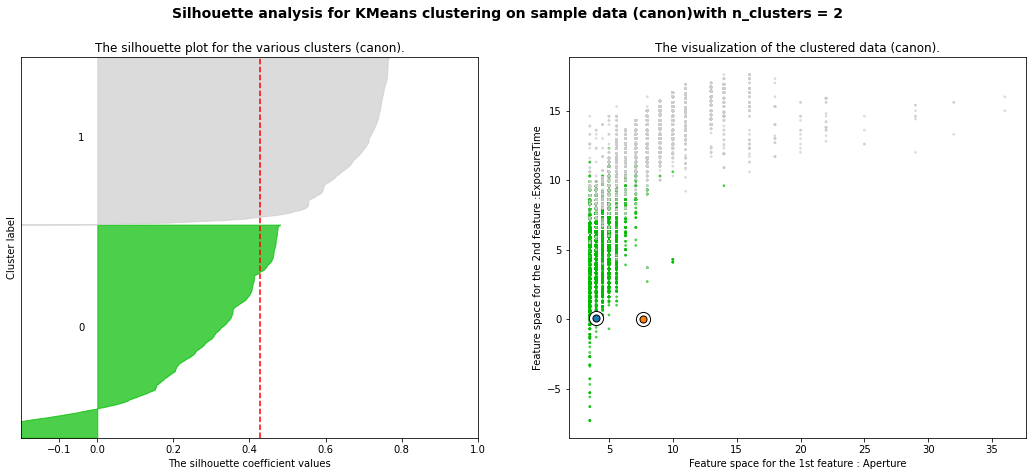

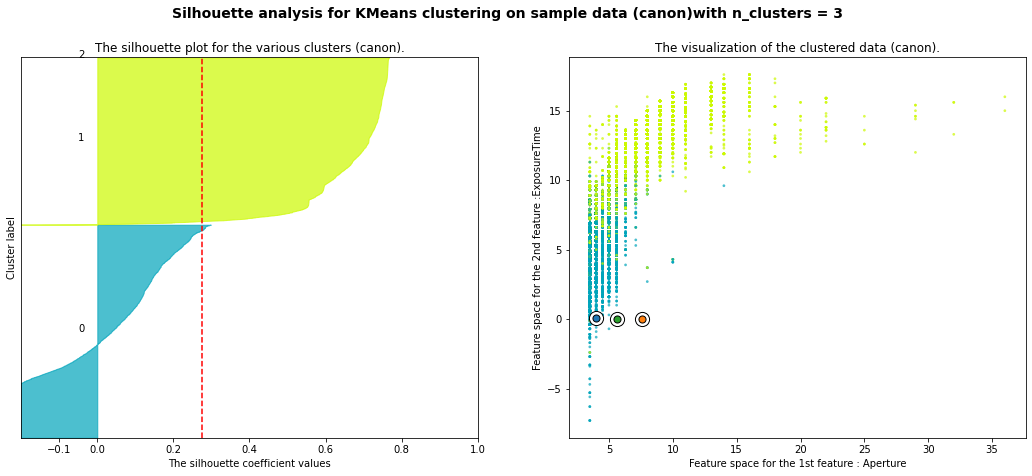

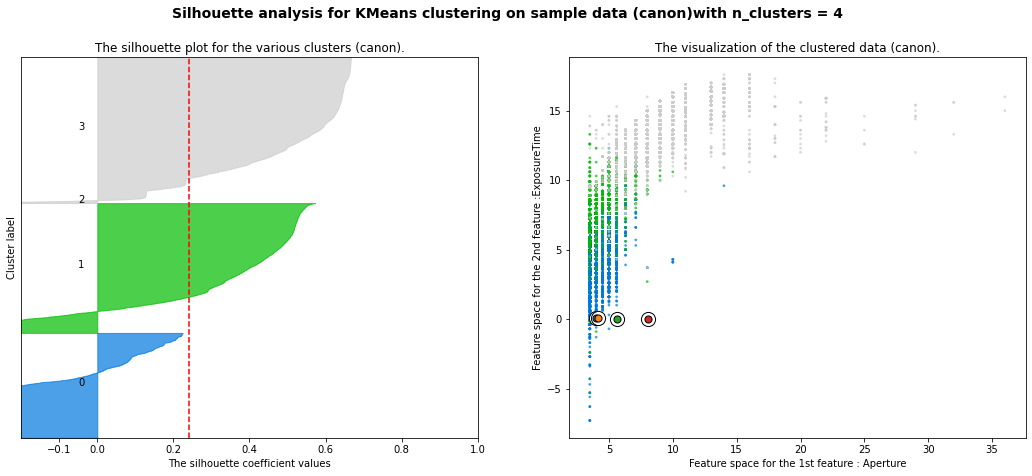

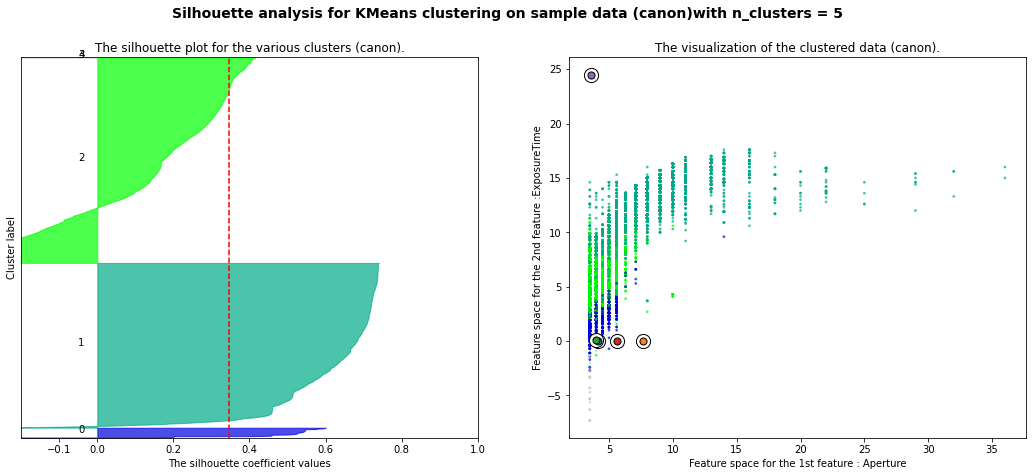

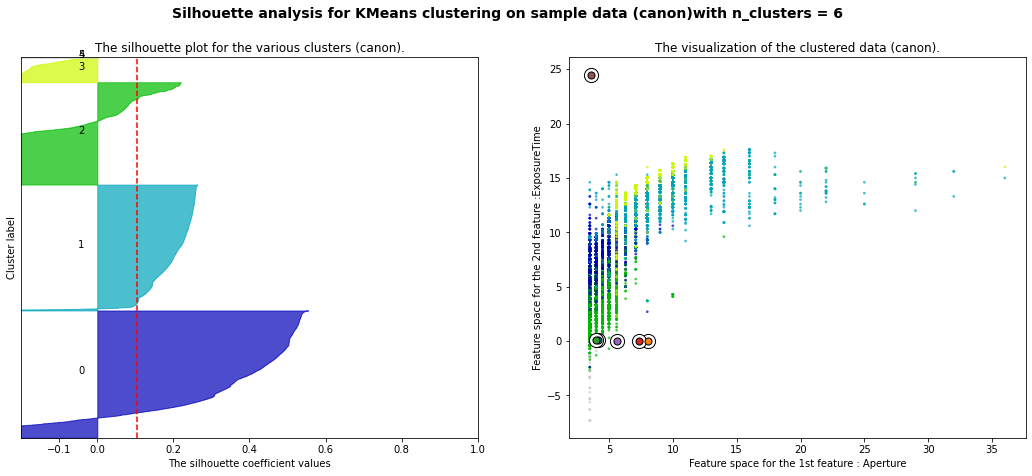

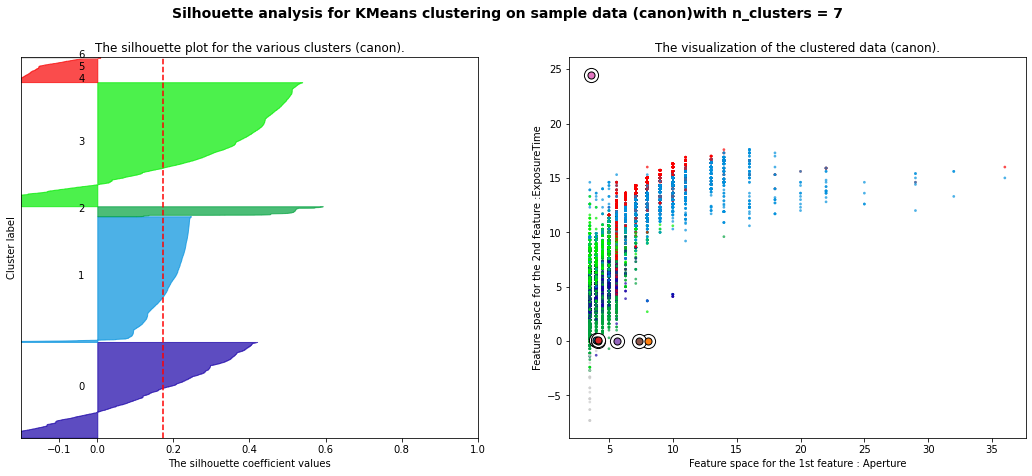

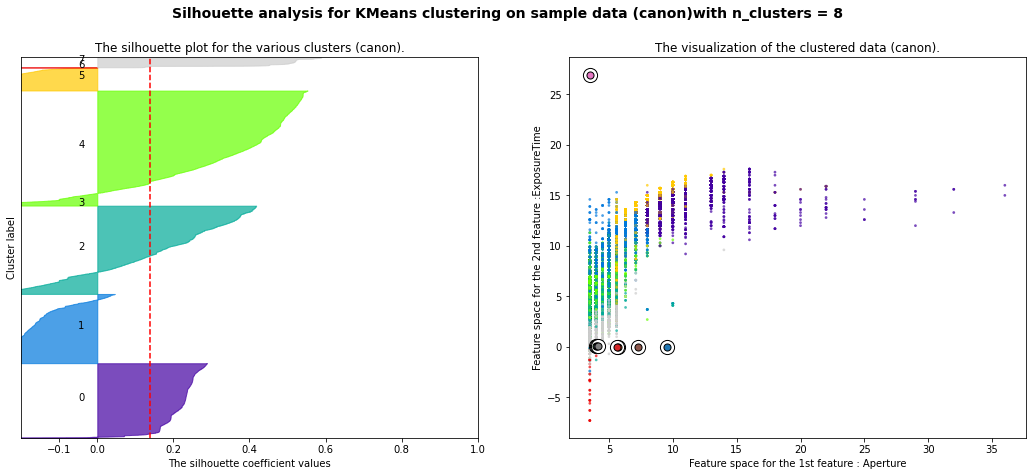

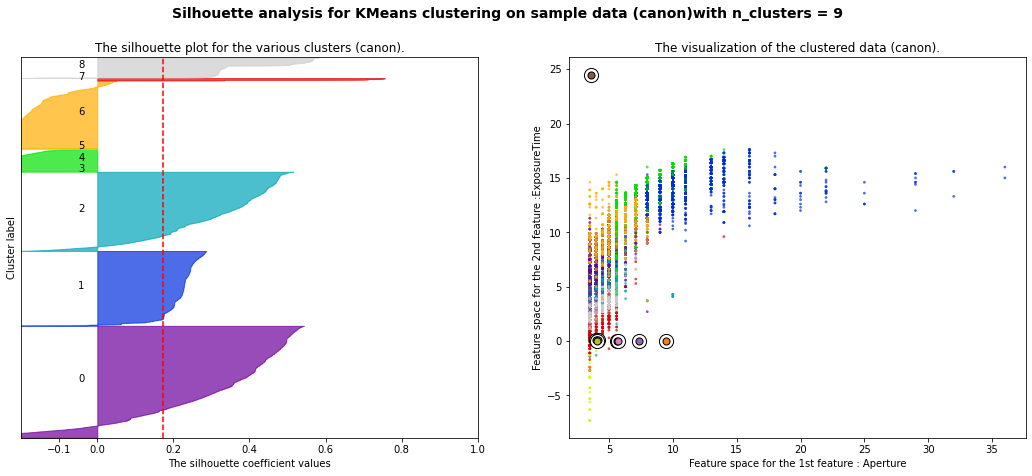

In [65]:
range_n_clusters = range(2, 10)

r_seed = 17

cols = col_for_cluster

cluster_errors_canon = []
silhouette_s_canon = []

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_nona_col_for_cluster[col_for_cluster]) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline_canon = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))])
    
    cluster_labels_canon = kmeans_pipeline_canon.fit_predict(df_nona_col_for_cluster[col_for_cluster])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg_canon = silhouette_score(df_nona_col_for_cluster[col_for_cluster], cluster_labels_canon)
    print("For n_clusters =",
          n_clusters,
          "The average silhouette_score is :",
          silhouette_avg_canon)

    # Compute the silhouette scores for each sample
    sample_silhouette_values_canon = silhouette_samples(df_nona_col_for_cluster[col_for_cluster], cluster_labels_canon)

    cluster_errors_canon.append(kmeans_pipeline_canon.named_steps["cluster"].inertia_)
    silhouette_s_canon.append(silhouette_avg_canon)
    #print('cluster calculation finished, start plotting')
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values_canon[cluster_labels_canon == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters (canon).")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_canon, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #print('sihouette and cluster plots for cluster number: ',n_clusters)
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels_canon.astype(float) + 1) / n_clusters)
    ax2.scatter(df_nona_col_for_cluster['Aperture'], 
                df_nona_col_for_cluster['LightValue'], 
                marker=".", 
                s=30, 
                lw=0, 
                alpha=0.7, 
                c=colors, 
                edgecolor="k")

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline_canon.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline_canon.named_steps["scaler"].inverse_transform(pipeline_centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data (canon).")
    ax2.set_xlabel("Feature space for the 1st feature : " + cols[0])
    ax2.set_ylabel("Feature space for the 2nd feature :" + cols[1])

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data (canon)"
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
plt.show()

In [66]:
import umap

reducer = umap.UMAP(n_components=2,
     n_neighbors=10,verbose=1)
X_umap = reducer.fit_transform(df_nona_col_for_cluster[col_for_cluster])

UMAP(n_neighbors=10, verbose=1)
Construct fuzzy simplicial set
Sun Jan 31 23:52:50 2021 Finding Nearest Neighbors
Sun Jan 31 23:52:50 2021 Building RP forest with 18 trees
Sun Jan 31 23:53:14 2021 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
Sun Jan 31 23:53:27 2021 Finished Nearest Neighbor Search
Sun Jan 31 23:53:32 2021 Construct embedding


/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jan 31 23:55:46 2021 Finished embedding


In [70]:
n_clusters_test=5
kmeans_pipeline_canon = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=n_clusters_test, random_state=r_seed, verbose=0))])
    
cluster_labels_canon = kmeans_pipeline_canon.fit_predict(df_nona_col_for_cluster[col_for_cluster])
cluster_labels_canon

array([3, 1, 1, ..., 1, 1, 1], dtype=int32)

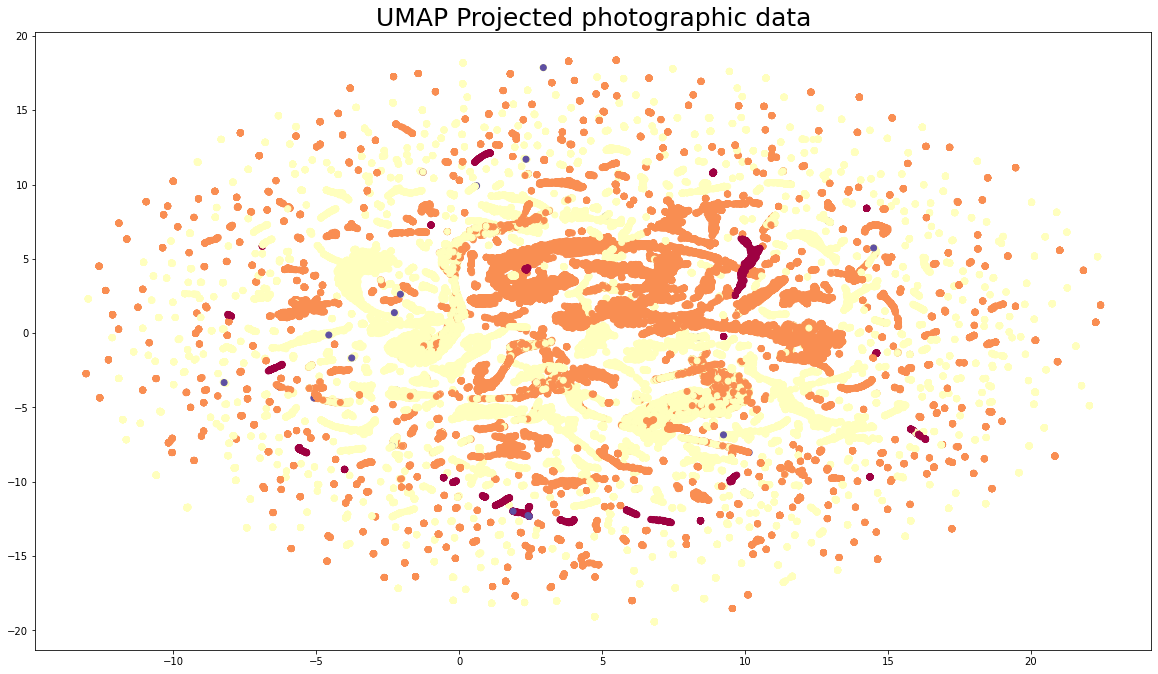

In [71]:
fig = plt.figure(figsize=(20,25))

# plot projected roll
ax = fig.add_subplot(212)
ax.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_canon, cmap=plt.cm.Spectral)
plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('UMAP Projected photographic data',fontsize=25)
plt.show()

In [68]:
X_umap_w_olymp = reducer.fit_transform(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp])

UMAP(n_neighbors=10, verbose=1)
Construct fuzzy simplicial set
Sun Jan 31 23:56:51 2021 Finding Nearest Neighbors
Sun Jan 31 23:56:51 2021 Building RP forest with 20 trees
Sun Jan 31 23:56:55 2021 NN descent for 17 iterations
	 0  /  17
	 1  /  17
Sun Jan 31 23:57:04 2021 Finished Nearest Neighbor Search
Sun Jan 31 23:57:06 2021 Construct embedding


/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Feb  1 00:05:58 2021 Finished embedding


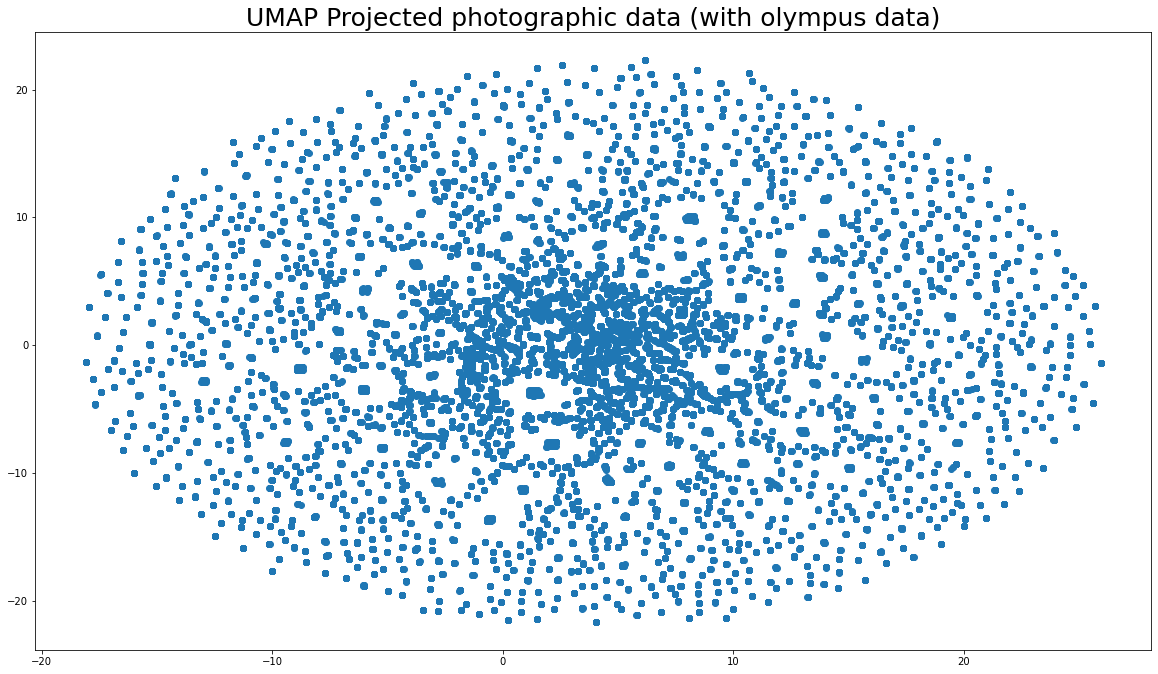

In [69]:
fig = plt.figure(figsize=(20,25))

# plot projected roll
ax = fig.add_subplot(212)
ax.scatter(X_umap_w_olymp[:, 0], X_umap_w_olymp[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
#plt.xticks([]), plt.yticks([])
plt.title('UMAP Projected photographic data (with olympus data)',fontsize=25)
plt.show()

In [72]:
from sklearn.decomposition import PCA

In [73]:
pca_95 = PCA(n_components=0.99999,random_state=17)


pip_pca_95=Pipeline(steps=[('sc', sc), ('pca', pca_95)])


X_pca_min_95 = pip_pca_95.fit_transform(df_nona_col_for_cluster_w_olymp[col_for_cluster_w_olymp])
print(pca_95.explained_variance_ratio_)
print(len(X_pca_min_95),len(pca_95.explained_variance_ratio_))

[0.41242259 0.20250006 0.19486376 0.15762919 0.03258439]
95859 5


Text(0, 0.5, 'sum of explained variances')

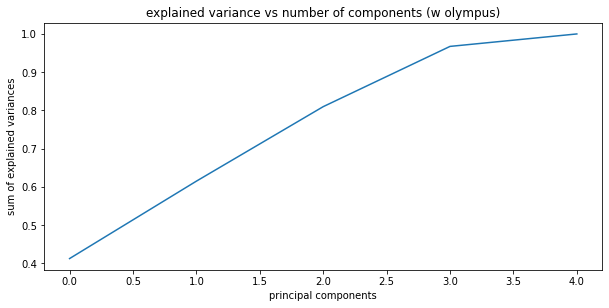

In [74]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.plot(np.cumsum(pca_95.explained_variance_ratio_))
plt.title("explained variance vs number of components (w olympus)")
plt.xlabel("principal components")
plt.ylabel("sum of explained variances")

In [75]:
pca_95 = PCA(n_components=0.99999,random_state=17)


pip_pca_95=Pipeline(steps=[('sc', sc), ('pca', pca_95)])


X_pca_min_95 = pip_pca_95.fit_transform(df_nona_col_for_cluster[col_for_cluster])
print(pca_95.explained_variance_ratio_)
print(len(X_pca_min_95),len(pca_95.explained_variance_ratio_))

[0.46731511 0.11530684 0.11112168 0.10941443 0.0898106  0.06827784
 0.02320886 0.00812509 0.00741956]
69868 9


Text(0, 0.5, 'sum of explained variances')

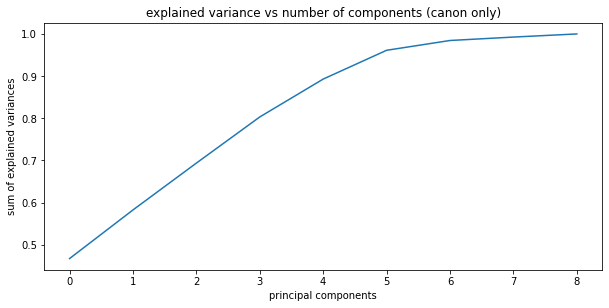

In [76]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.plot(np.cumsum(pca_95.explained_variance_ratio_))
plt.title("explained variance vs number of components (canon only)")
plt.xlabel("principal components")
plt.ylabel("sum of explained variances")

In [77]:
ind90=np.argwhere(np.cumsum(pca_95.explained_variance_ratio_) >= 0.90)[0]
print(ind90)

[5]
